# Marginalization


In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import PrecisionRecallDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install scikit-learn==1.2.2 ltcn shap

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.3 MB/s eta 0:00:00
  Created wheel for ltcn: filename=ltcn-0.1.0-py3-none-any.whl size=3299 sha256=5379797a1db4d22e892b73dae024f49d45f75a5fe4754c4f1a32896274542136
  Stored in directory: /root/.cache/pip/wheels/ad/4e/78/6b34a5e67349c2f1fe1e4792cb5b4aeaf4a82be167703f5608
Successfully built ltcn


In [ ]:
pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


#Model

In [ ]:
from ltcn.LTCN import LTCN
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

In [ ]:
with open('/content/drive/MyDrive/Thesis/RLTCN_model.pkl', 'rb') as file:
    best_ltcn = pickle.load(file)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Thesis/encoded_A14I_dataset")

feature_columns = ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
target_column = ['Machine failure']

X = df[feature_columns].to_numpy()
Y = df[target_column].to_numpy()

#Interpretability

##Relevance Score

In [ ]:
def compute_scores(ltcn):

    """
    Compute the feature relevance scores of the LTCN model

    Parameters:
    - ltcn: LTCN-based classifier

    Returns:
    numpy.ndarray: An array containing the normalized scores

    Notes:
    - The scores are normalized, son their sum will be one

    """

    if ltcn.method == 'ridge':
        W = ltcn.model.coef_.T
    else:
        W = ltcn.W2[:-1,:]

    n_features = int(W.shape[0] / (ltcn.T + 1))
    scores = np.zeros((n_features, W.shape[1]))

    for i in range(0, W.shape[0], n_features):
        scores += np.absolute(W[i:(i+n_features), :])

    mean_scores = np.mean(scores, axis=1)

    return mean_scores / np.sum(mean_scores)

In [ ]:
relevance_scores = compute_scores(best_ltcn.named_steps['classifier'] )
relevance_scores

array([0.16639062, 0.10025286, 0.23924736, 0.18526848, 0.1808537 ,
       0.12798699])

##SHAP

In [ ]:
X = df[feature_columns].to_numpy()
Y = df[target_column].to_numpy()

In [ ]:
import shap

background_kmeans = shap.kmeans(X, 5)
explainer = shap.KernelExplainer(best_ltcn.predict, background_kmeans)
shap_values = explainer.shap_values(X)

  0%|          | 0/9981 [00:00<?, ?it/s]

In [ ]:
feature_columns = ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

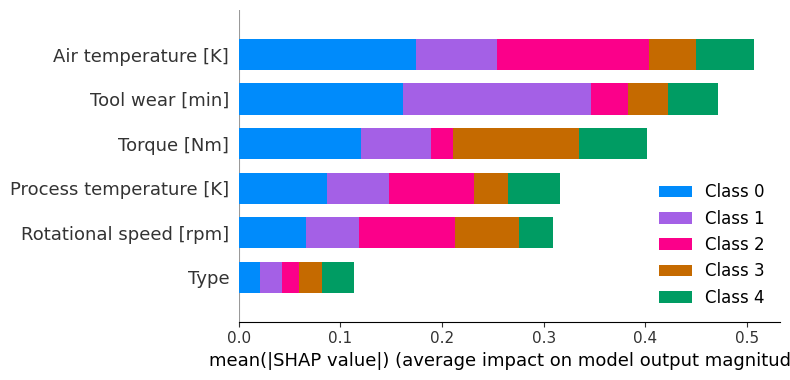

In [ ]:
shap.summary_plot(shap_values[:], X, feature_names=feature_columns)

In [ ]:
SHAP = [1,5,4,2,3,0]

##Permutation Feature Importance

In [ ]:
X = df[feature_columns].to_numpy()
Y = df[target_column].to_numpy()

In [ ]:
def custom_f1_pfi(y_true, y_pred):
    return f1_score(y_true, np.argmax(y_pred, axis=1), average="weighted")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(custom_f1_pfi)
results = permutation_importance(best_ltcn, X, Y, scoring=f1_scorer, random_state=42)
pfi_means = results.importances_mean

In [ ]:
pfi_means

array([0.0004614 , 0.07246444, 0.06505839, 0.01456139, 0.01923987,
       0.01254901])

#Pixel Flip

In [ ]:
indices_relevance_score = np.argsort(-relevance_scores).tolist()
indices_pfi = np.argsort(-pfi_means).tolist()
indices_shap = SHAP

indices_relevance_score, indices_pfi, indices_shap

([2, 3, 4, 0, 5, 1], [1, 2, 4, 3, 5, 0], [1, 5, 4, 2, 3, 0])

In [ ]:
random_shuffle = [0, 1, 2, 3, 4, 5]
random.shuffle(random_shuffle)

In [ ]:
def custom_f1_pixel_flip(y_true, y_pred):
    classes_of_interest = [1, 2, 3, 4]
    f1_scores = f1_score(y_true, np.argmax(y_pred, axis=1), labels=classes_of_interest, average="weighted")
    return f1_scores

In [ ]:
def pixel_experiment(input_list, X, Y, best_model):
    y_pred = best_model.predict(X)
    score_to_append = custom_f1_pixel_flip(Y, y_pred)

    f1_scores_iterative_marginalization = []
    f1_scores_iterative_marginalization.append(score_to_append)
    X_full = np.copy(X)

    for i in input_list:
        mean = np.mean(X_full[:, i])
        X_full[:, i] = mean
        y_pred_full_mod = best_model.predict(X_full)
        f1_full_mod = custom_f1_pixel_flip(Y, y_pred_full_mod)
        f1_scores_iterative_marginalization.append(f1_full_mod)

    print("F1 scores after every iteration", f1_scores_iterative_marginalization)

    return f1_scores_iterative_marginalization

In [ ]:
X = df_multi[feature_columns].to_numpy()
Y = df_multi[target_column].to_numpy()

In [ ]:
pixel_flip_relevance = pixel_experiment(indices_relevance_score, X, Y, best_ltcn)
pixel_flip_shap = pixel_experiment(indices_shap, X, Y, best_ltcn)
pixel_flip_pfi = pixel_experiment(indices_pfi, X, Y, best_ltcn)
pixel_flip_shuffle = pixel_experiment(random_shuffle, X, Y, best_ltcn)

In [ ]:
import numpy as np
from scipy.integrate import simps

In [ ]:
def calculate_auc(x_values, *lists):
    auc_values = {f'List {i+1}': simps(lists[i], x_values) for i in range(len(lists))}
    for name, auc in auc_values.items():
        print(f"AUC of {name}: {auc}")
    return auc_values

In [ ]:
# Calculate and print the AUCs
calculate_auc(range(0, 7), pixel_flip_relevance, pixel_flip_shap, pixel_flip_pfi, pixel_flip_shuffle)